In [88]:
# Libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import joblib

import tensorflow as tf
from tensorflow import keras

# Dataset

In [29]:
# Load the Dataset
df = pd.read_csv('/kaggle/input/malicious-urls-dataset/malicious_phish.csv')

Text(0.5, 0, 'Attacks')

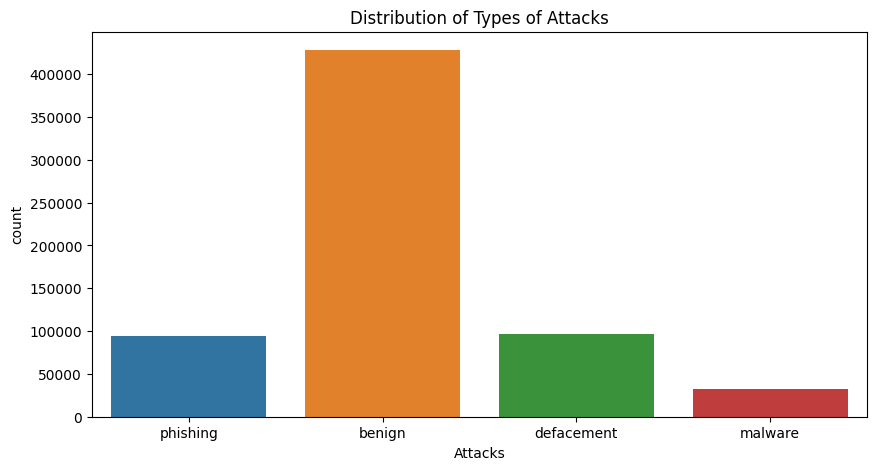

In [30]:
plt.figure(figsize= (10 , 5))
plt.title('Distribution of Types of Attacks')
sns.countplot(x = 'type', data = df)
plt.xlabel('Attacks')

# Feature Engineering

## IP address:
Generally cyber attackers use an IP address in place of the domain name to hide the identity of the website. this feature will check whether the URL has IP address or not.

In [31]:
# Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    
    
    if match:

        return 1
    else:

        return 0

df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))
df[df['use_of_ip'] == 1]

,url,type,use_of_ip
10408,http://219.232.244.89/intl/update/error_login.htm,phishing,1
12441,boards.ancestry.com/topics.ethnic.natam.nation...,benign,1
12853,http://www.controlyourbreath.com/new/css_/img/...,phishing,1
13161,http://www.reqntpvw.com/Public/softs/everythin...,malware,1
14915,http://66.208.115.70/images/index.asp,phishing,1
...,...,...,...
598624,helapharm.ro/css_/img/webscr/cmd_/e2tUc17DNO4H...,benign,1
598638,helapharm.ro/css_/img/webscr/cmd_/e2tUc17DNO4H...,benign,1
601657,www.mairie-saint-avold.fr/admin/125.14.226.143...,benign,1
601697,www.mairie-saint-avold.fr/admin/190.244.107.16...,benign,1


## Abnormal URL
This feature can be extracted from the WHOIS database. For a legitimate website, identity is typically part of its URL.

In [32]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:      
        return 1
    else:
       
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

## Google Index:
In this feature, we check whether the URL is indexed in google search console or not.

In [33]:
 # pip install googlesearch-python

Note: you may need to restart the kernel to use updated packages.


In [34]:
from googlesearch import search

In [35]:
def google_index(url):
    
    site = search(url, 5)
    return 1 if site else 0

df['google_index'] = df['url'].apply(lambda i: google_index(i))

## Count dot (.):
The phishing or malware websites generally use more than two sub-domains in the URL. Each domain is separated by dot (.). If any URL contains more than three dots(.), then it increases the probability of a malicious site.

In [36]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))

## Count www:Generally most of the safe websites have one www in its URL. This feature helps in detecting malicious websites if the URL has no or more than one www in its URL.


In [37]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

## Count @:
The presence of the “@” symbol in the URL ignores everything previous to it.

In [38]:
def count_atrate(url):
     
    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))

## Count Directories:
The presence of multiple directories in the URL generally indicates suspicious websites.

In [39]:
def no_of_dir(url):
    urldir = urlparse(url).path
#     print(urldir)
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

## Count Embed Domain:
The number of the embedded domains can be helpful in detecting malicious URLs. It can be done by checking the occurrence of “//” in the URL.

In [40]:
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domain'] = df['url'].apply(lambda i: no_of_embed(i))

In [41]:
def no_of_embed(url):
    urldir = urlparse(url).path
    
    print(urldir)
    return urldir.count('//')

print(df['url'][7])
no_of_embed(df['url'][7])

yourbittorrent.com/?q=anthony-hamilton-soulife
yourbittorrent.com/


0

## Count sus words
Malicious URLs generally contain suspicious words in the URL such as PayPal, login, sign in, bank, account, update, bonus, service, ebayisapi, token, etc. We have found the presence of such frequently occurring suspicious words in the URL as a binary variable i.e., whether such words present in the URL or not.

In [42]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
    
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

## Short URLs
This feature is created to identify whether the URL uses URL shortening services like bit. \ly, goo.gl, go2l.ink, etc.

In [43]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

## Count HTTPS:
Generally malicious URLs do not use HTTPS protocols as it generally requires user credentials and ensures that the website is safe for transactions. So, the presence or absence of HTTPS protocol in the URL is an important feature.


In [44]:
def count_https(url):
    return url.count('https')

df['count_https'] = df['url'].apply(lambda i : count_https(i))

## Count HTTP:
Most of the time, phishing or malicious websites have more than one HTTP in their URL whereas safe sites have only one HTTP.

In [45]:
def count_http(url):
    return url.count('http')

df['count_http'] = df['url'].apply(lambda i : count_http(i))

## Count %:
URLs cannot contain spaces. URL encoding normally replaces spaces with symbol (%). Safe sites generally contain less number of spaces whereas malicious websites generally contain more spaces in their URL hence more number of %.

In [46]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

## Count (?):
The presence of symbol (?) in URL denotes a query string that contains the data to be passed to the server. More number of ? in URL definitely indicates suspicious URL.

In [47]:
def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

## Count (-):
Phishers or cybercriminals generally add dashes (-) in prefix or suffix of the brand name so that it looks genuine URL. For example: www.flipkart-india.com.

In [49]:
def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

## Count (=):
Presence of equal to (=) in URL indicates passing of variable values from one form page to another. It is considered as riskier in URL as anyone can change the values to modify the page.


In [50]:
def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

## URL Length:
Attackers generally use long URLs to hide the domain name. We found the average length of a safe URL is 74.

In [51]:
def url_length(url):
    return len(str(url))

df['url_length'] = df['url'].apply(lambda i: url_length(i))

## Hostname Length:
The length of the hostname is also an important feature for detecting malicious URLs.

In [53]:
def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

## First directory length:
This feature helps in determining the length of the first directory in the URL. So looking for the first ‘/’ and counting the length of the URL up to this point helps in finding the first directory length of the URL. For accessing directory level information we need to install python library TLD. You can check this link for installing TLD.

In [54]:
# pip install tld

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 8.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [56]:
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

## Length of top-level domains:
A top-level domain (TLD) is one of the domains at the highest level in the hierarchical Domain Name System of the Internet. For example, in the domain name www.example.com, the top-level domain is com. So, the length of TLD is also important in identifying malicious URLs. As most of the URLs have .com extension. TLDs in the range from 2 to 3 generally indicate safe URLs.

In [57]:
#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

## Count Digits:
The presence of digits in URL generally indicate suspicious URLs. Safe URLs generally do not have digits so counting the number of digits in URL is an important feature for detecting malicious URLs.


In [59]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits += 1
    return digits


df['count_digits']= df['url'].apply(lambda i: digit_count(i))

## Count Letters:
The number of letters in the URL also plays a significant role in identifying malicious URLs. As attackers try to increase the length of the URL to hide the domain name and this is generally done by increasing the number of letters and digits in the URL.


In [61]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters += 1
    return letters


df['count_letters']= df['url'].apply(lambda i: letter_count(i))

# Store and use the preprocessed CSV

In [62]:
df.to_csv("preprocessed_data.csv")
df = pd.read_csv("preprocessed_data.csv", low_memory=False)

# Label encoding

In [67]:
label_encoder = LabelEncoder()

df['type_code'] = label_encoder.fit_transform(df['type'])

# Creation of Feature & Target

In [68]:
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domain', 'short_url', 'count%', 'count?', 'count-', 'count=', 'url_length', 'count_https',
       'count_http', 'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count_digits',
       'count_letters']]

Y = df['type_code']

# Split Dataset

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2 , shuffle = True, random_state = 42)
X_train.shape , Y_train.shape

((520952, 21), (520952,))

# Scale Features

Model performs better and converges faster.

In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ML Model
## Classification Report Function

In [73]:
def result(y_pred , y_test):
    accuracy = accuracy_score(y_test, y_pred) * 100
#     print(accuracy)
    
    precision , recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    
    res = {
        "Accuracy": accuracy,
        "Precision" : precision,
        "Recall" : recall,
        "F1-Score" : f1_score,
        "Support" : support
    }
    
    print(classification_report(y_test, y_pred ,target_names=['benign', 'defacement','phishing','malware']))
    
    return res

## Confusion Matrix Function

In [74]:
def create_confusion_metric(y_pred , y_test):
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True,fmt=".1f")
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    
    plt.show()

## Define Model

In [89]:
# Define classification models
models = {
    "Logistic_Regression": LogisticRegression(max_iter=300),
    # "Decision Tree": DecisionTreeClassifier(),
    # "Random Forest": RandomForestClassifier(),
    # "Gradient Boosting": GradientBoostingClassifier(),
    # "XGBoost": XGBClassifier(),
    # "CatBoost": CatBoostClassifier(verbose=False),
    # "AdaBoost": AdaBoostClassifier()
}

## Train and Eval Model

Training Logistic_Regression...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


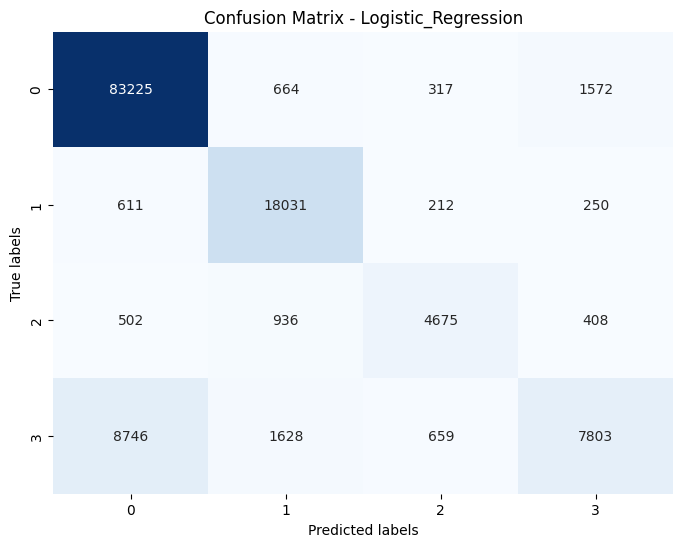


Logistic_Regression classifier: Training Results
Training accuracy: 0.8732551175540165
Training precision: 0.8654777030994298
Training recall: 0.8732551175540165
Training F1 score: 0.8598493506713553

Logistic_Regression classifier: Testing Results
Testing accuracy: 0.8732714471
Testing Precision: 0.8656784351
Testing Recall: 0.8732714471
Testing F1 score: 0.8599541836



In [90]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Fit model to training data
    model.fit(X_train_scaled, Y_train)
    
    # Make predictions on training and testing data
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate performance metrics for Train Data
    train_accuracy = accuracy_score(Y_train, y_train_pred)
    train_precision = precision_score(Y_train, y_train_pred, average='weighted')
    train_recall = recall_score(Y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(Y_train, y_train_pred, average='weighted')
    
    
    # Calculate performance metrics for Test Data
    accuracy = accuracy_score(Y_test, y_test_pred)
    precision = precision_score(Y_test, y_test_pred, average='weighted')
    recall = recall_score(Y_test, y_test_pred, average='weighted')
    f1 = f1_score(Y_test, y_test_pred, average='weighted')
    
    # Generate confusion matrix
    cm = confusion_matrix(Y_test, y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    print(""*5)
    # Print results Train Data
    print(f"{model_name} classifier: Training Results")
    print("Training accuracy:", train_accuracy)
    print("Training precision:", train_precision)
    print("Training recall:", train_recall)
    print("Training F1 score:", train_f1)
    print("="*50)
    print(""*5)
    
    # Print results Test Data
    print(f"{model_name} classifier: Testing Results")
    print(f"Testing accuracy: {accuracy:.10f}")
    print(f"Testing Precision: {precision:.10f}")
    print(f"Testing Recall: {recall:.10f}")
    print(f"Testing F1 score: {f1:.10f}")
    print("="*50)
    print(""*5)

## Save the Trained Model

In [92]:
joblib.dump(models["Logistic_Regression"], 'model.joblib')

['model.joblib']